In [1]:
# ================================================================================================================
# Figure 4: Worst-in-century (WIC) rainfall return periods of 10,000 bootstrap samples across New Zealand
# Purpose: Illustrate the spatial variability and sampling uncertainty of extreme 1-day rainfall using
#          bootstrap resampling and GEV-based return periods.
# Inputs: Weather@Home Rx1d dataset (stationary 2006–2015 ensemble), 3226 model years.
# Outputs:
#   (a) Return periods of WIC rainfall across New Zealand for each bootstrap sample, showing the
#       fraction of the country exceeding 100-year thresholds.
#   (b) Map of return periods at the 1st percentile of bootstrap samples.
#   (c) Map of return periods at the 99th percentile of bootstrap samples.
# ================================================================================================================

In [2]:
# ---------------------------------------------------------------
# Section 1: Import required libraries
# ---------------------------------------------------------------

from scipy.stats import genextreme as gev
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec # For flexible subplot layouts if needed

# Set default plot font for consistency
plt.rcParams["font.family"] = "Arial"

-------

In [3]:
# ---------------------------------------------------------------
# Section 2: Load Rx1d rainfall data
# ---------------------------------------------------------------

# Load the Weather@Home Rx1d data (stationary 2006–2015 ensemble)
rainfall_data = xr.open_dataset('../Weather@home Data/Aotearoa Rx1d Weather@home Data Specified Land-Sea Mask - Stationary Climate.nc')['item5216_daily_mean']

# Convert to numpy arrays
rx1d_data = np.array(rainfall_data)
latitude = np.array(rainfall_data['global_latitude0'])
longitude = np.array(rainfall_data['global_longitude0'])

-----------

In [4]:
# ------------------------------------------------------------------
# Section 3: Bootstrap resampling to estimate worst-in-century (WIC)
# ------------------------------------------------------------------

full_ensemble_size = rx1d_data.shape[0] # 3,226 model years in full ensemble

# Prepare output array of bootstrap resampling
num_outer = 10000 # Number of bootstrap iterations
n_lat = rx1d_data.shape[1]  # Number of latitude points
n_lon = rx1d_data.shape[2]  # Number of longitude points

# Initialize array to store maximum rainfall in each bootstrap sample at each grid cell
bootstrap_output = np.empty((num_outer, n_lat, n_lon))

for i in range(num_outer):
    # Randomly resample 100 years (with replacement) from the full ensemble
    resampled_indices = np.random.choice(full_ensemble_size, size=100, replace=True)
    bootstrap_sample = rx1d_data[resampled_indices] # Get the bootstrap sample. Shape: (100, n_lat, n_lon)

    # Take the maximum along the resampled years for each grid cell
    # This represents the "worst-in-century" (WIC) rainfall for this bootstrap iteration
    bootstrap_output[i] = bootstrap_sample.max(axis=0)

-------

In [5]:
# ---------------------------------------------------------------
# Section 4: Compute return periods of bootstrap WIC values
# ---------------------------------------------------------------

# Initialize array to store return periods for each bootstrap sample at each grid cell
return_periods_bootstrap_output = np.full((num_outer, n_lat, n_lon), np.nan)

# Loop over each grid cell
for j in range(n_lat):
    for k in range(n_lon):
        # Selecting annual maximum 1-day rainfall at this grid cell across full ensemble
        grid_cell_rx1d = rx1d_data[:,j,k]

        # Check if all values are NaN
        if np.all(np.isnan(grid_cell_rx1d)):
            continue  # Skip this iteration if all values are NaN

        # Fit GEV to full 3,226-year dataset at this grid cell
        shape, loc, scale = gev.fit(grid_cell_rx1d, 0) # shape=0 for numerical stability in estimating extreme values

        # Compute return period for each bootstrap WIC value relative to fitted GEV
        for i in range(num_outer):
            selected_sample = bootstrap_output[i, j, k]  # Value from bootstrap sample
            return_periods_bootstrap_output[i, j, k] = 1 / (1 - (gev.cdf(selected_sample, shape, loc=loc, scale=scale)))

-------

In [6]:
# ---------------------------------------------------------------
# Section 5: Prepare data for plotting
# ---------------------------------------------------------------

# Compute percentage of New Zealand area where return period ≥ 100 years in each bootstrap sample
# 118 = total number of grid cells over New Zealand in the dataset
percent_area_above_100_years = (np.sum(return_periods_bootstrap_output >= 100, axis=(1, 2)) / 118) * 100

# Sort bootstrap samples by area fraction ≥ 100-year return period (optional: for plotting)
sorted_return_periods_bootstrap_output = return_periods_bootstrap_output[np.argsort(percent_area_above_100_years)]

# Identify New Zealand grid cells for aggregation (valid_grid_cells_of_new_zealand identifies which grid cells actually contain NZ data)
valid_grid_cells_of_new_zealand = ~np.isnan(sorted_return_periods_bootstrap_output[0])
nz_grid_cells = valid_grid_cells_of_new_zealand.sum()

# Create fraction of New Zealand for plotting exceedance curves (0–100%)
fraction = np.linspace(0, 100, nz_grid_cells)

# Aggregate and sort return periods across New Zealand grid cells for each bootstrap sample
aggregated_sorted_return_periods_bootstrap_output = np.full((num_outer, nz_grid_cells), np.nan) # Define a variable to store aggregated and sorted return periods for all bootstrap samples
for i in range(num_outer):
    aggregated_sorted_return_periods_bootstrap_output[i] = np.sort(sorted_return_periods_bootstrap_output[i][valid_grid_cells_of_new_zealand])

-------

In [7]:
# ---------------------------------------------------------------
# Section 6: Gridline setup function
# ---------------------------------------------------------------

def setup_gridlines(ax):
    # Configure gridlines, tick marks, and label formatting for Cartopy maps
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.05, linestyle='--', draw_labels=False)

    # Configure tick marks for both axes
    ax.tick_params(axis='both', which='both', direction='out', length=5, width=1, labelsize=10)
    ax.set_xticks(np.arange(160, 180, 2), crs=ccrs.PlateCarree())  # Longitude ticks
    ax.set_yticks(np.arange(-50, -30, 2), crs=ccrs.PlateCarree())  # Latitude ticks
    
    # Format longitude and latitude labels
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    
    # Ensure ticks are drawn on all sides
    ax.tick_params(left=True, bottom=True, right=True, top=True)
    
    return ax

-------

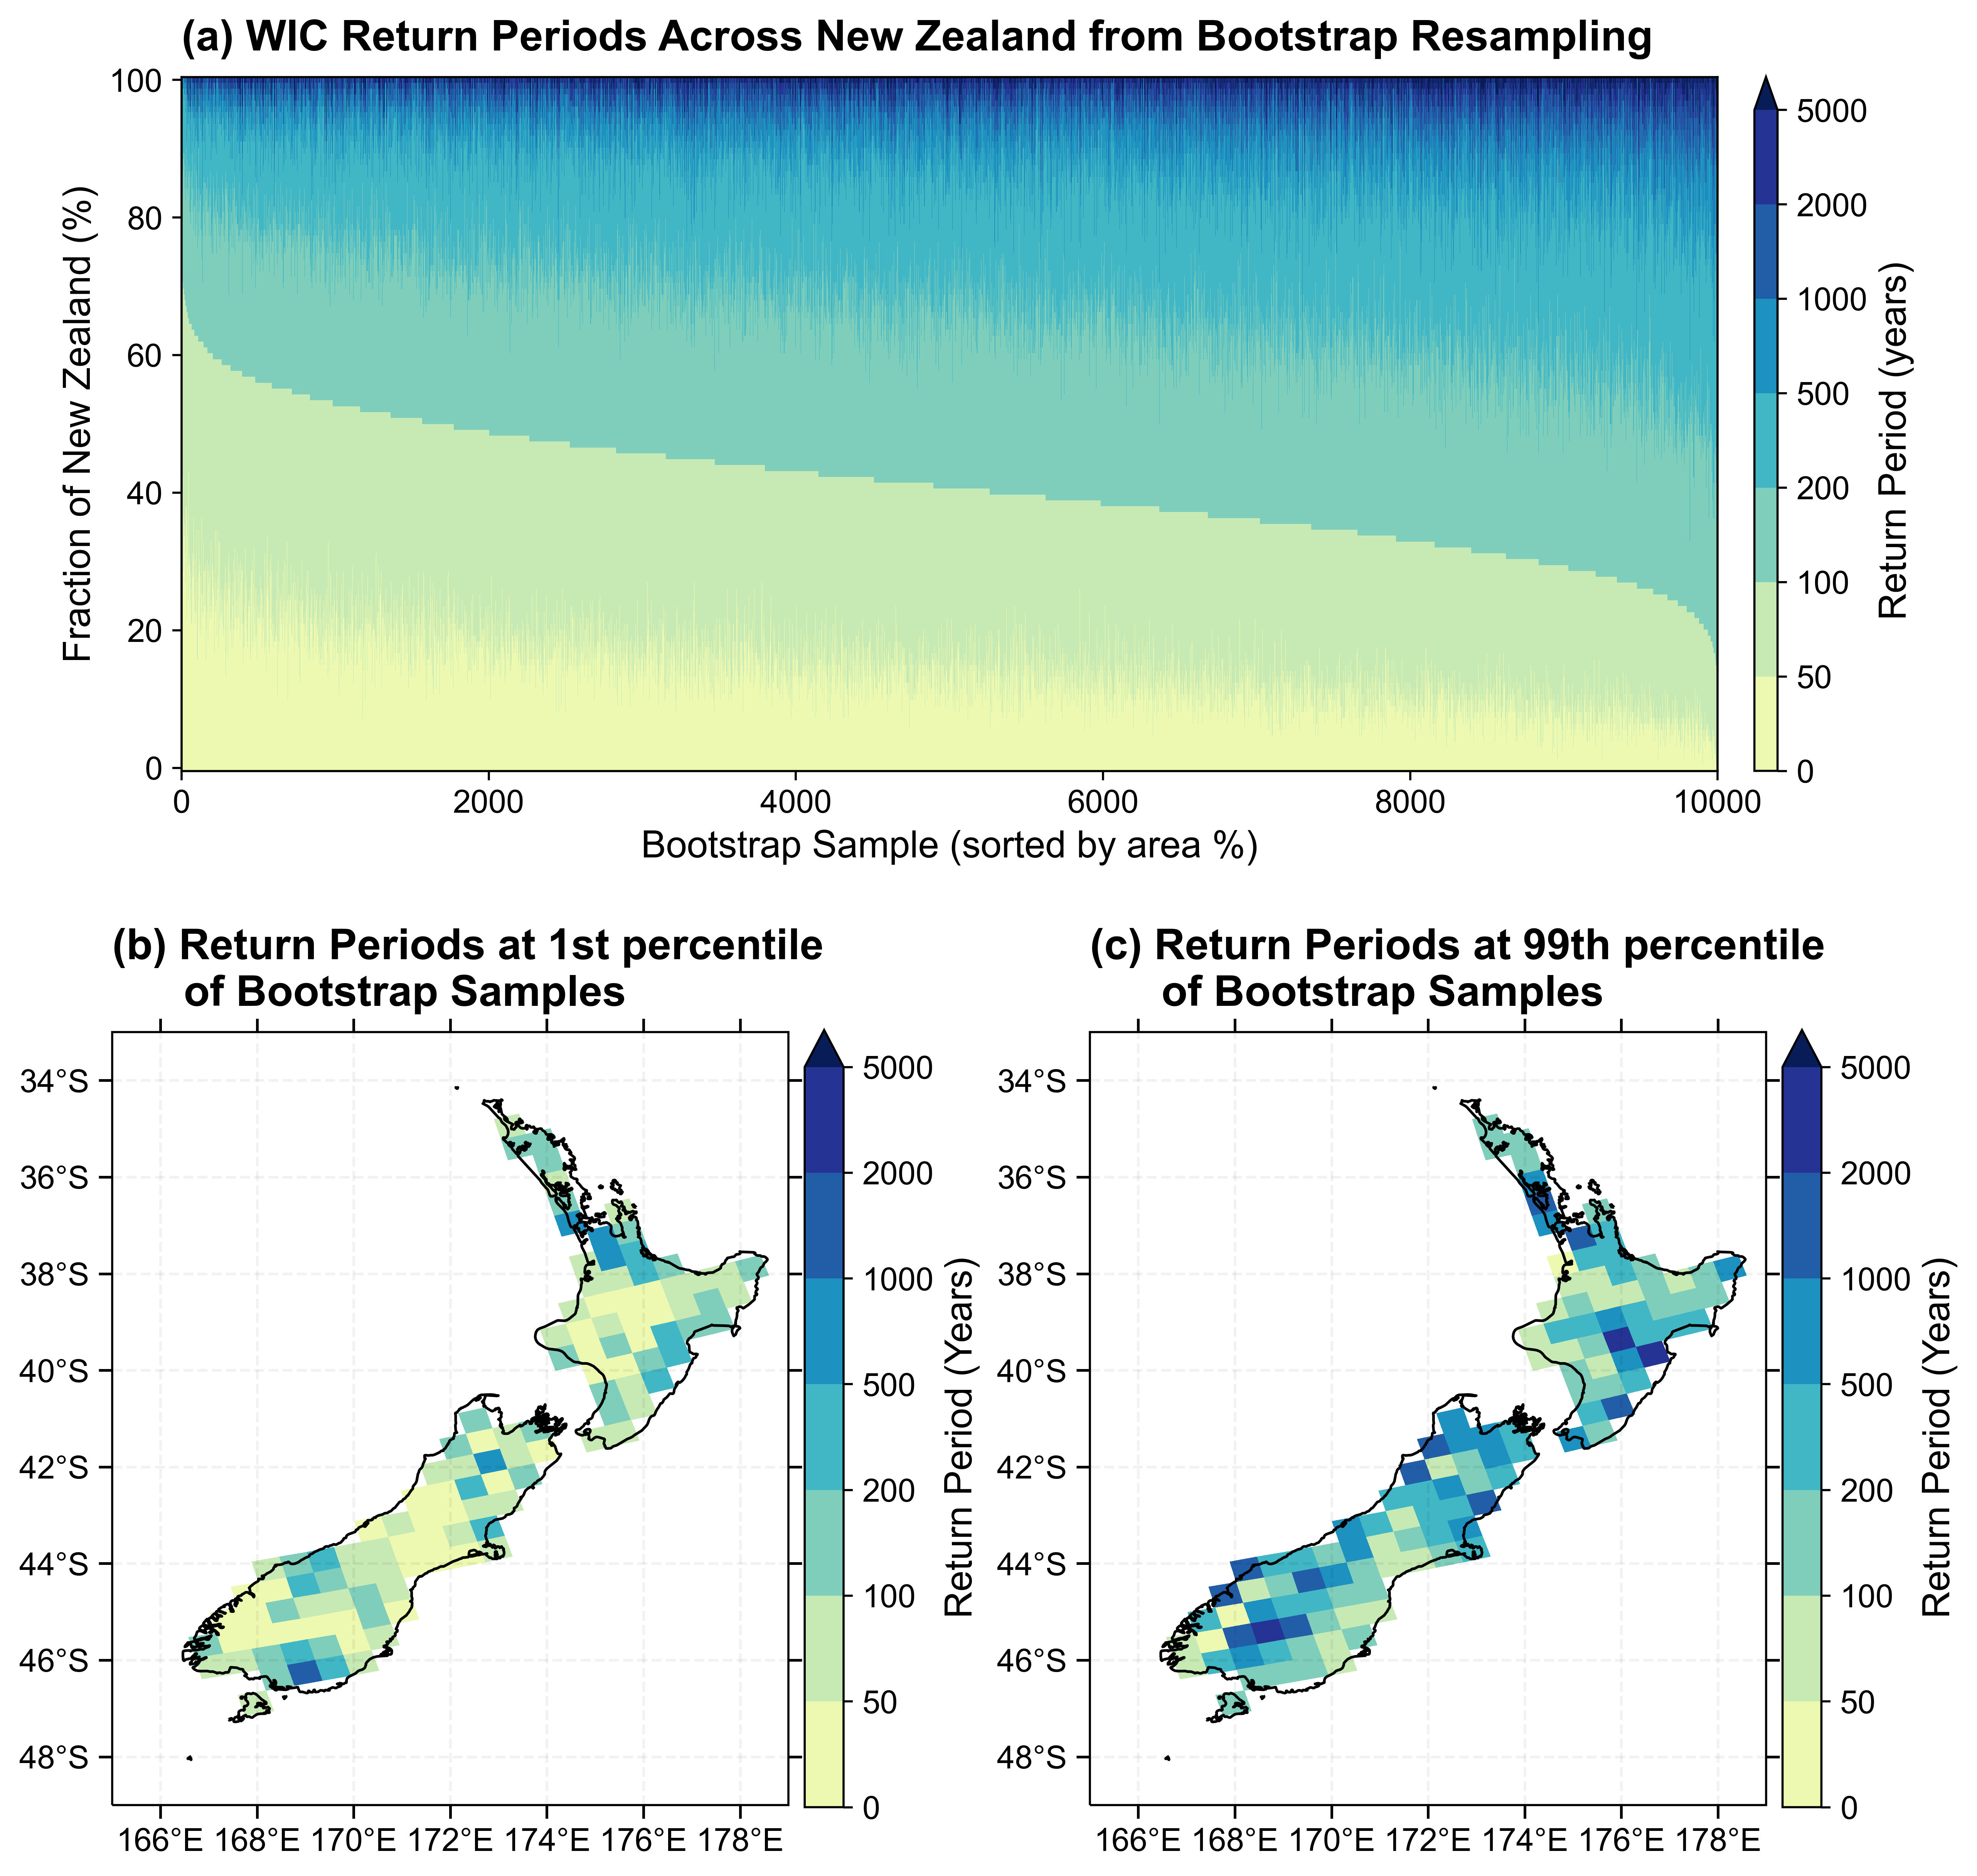

In [8]:
# ---------------------------------------------------------------
# Section 7: Create main figure
# ---------------------------------------------------------------

# Create figure with 2x2 grid layout
fig = plt.figure(figsize=(12, 12), dpi=500)
gs = gridspec.GridSpec(2, 2, width_ratios=[0.5, 0.5], height_ratios=[0.4, 0.6], hspace=0.2, wspace=0.2)

# ----------------------------
# Top row (a) — WIC Return Periods
# ----------------------------
ax0 = fig.add_axes([0.155, 0.6, 0.8, 0.3])  # Position: left, bottom, width, height

# Define color bins and colormap for return periods
bounds = [0, 50, 100, 200, 500, 1000, 2000, 5000]
cmap = ListedColormap(["#edf8b1", "#c7e9b4", "#7fcdbb", "#41b6c4", "#1d91c0", "#225ea8", "#253494"])
cmap.set_over("#081d58")  # Color for values above the last bound

# Plot bootstrap return periods across New Zealand (sorted by area fraction ≥ 100-year threshold)
mesh = ax0.pcolormesh(np.arange(num_outer), fraction, aggregated_sorted_return_periods_bootstrap_output.T, 
                      shading="auto", cmap=cmap, norm=BoundaryNorm(bounds, cmap.N, clip=False))

# Add colorbar with labels
cbar = fig.colorbar(mesh, ax=ax0, boundaries=bounds, extend='max', pad=0.02, aspect=30)
cbar.set_label('Return Period (years)', fontsize=14)
cbar.set_ticks(bounds)
cbar.set_ticklabels(["0", "50", "100", "200", "500", "1000", "2000", "5000"])
cbar.ax.tick_params(labelsize=12)

# Set axis labels and ticks
ax0.set_xticks([0, 2000, 4000, 6000, 8000, 10000])
ax0.set_yticks([0, 20, 40, 60, 80, 100])
ax0.set_xlabel('Bootstrap Sample (sorted by area %)', fontsize=14)
ax0.set_ylabel('Fraction of New Zealand (%)', fontsize=14)
ax0.tick_params(axis='both', labelsize=12)

# Set title
ax0.set_title("(a) WIC Return Periods Across New Zealand from Bootstrap Resampling",
              fontsize=16, weight='bold', loc='left', pad=10)

# ----------------------------
# Bottom row (b) & (c) — Spatial maps of 1st and 99th percentile bootstrap samples
# ----------------------------
axes = [fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree()), fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())]

# Select datasets and titles for the 1st and 99th percentile maps
datasets = [sorted_return_periods_bootstrap_output[99], sorted_return_periods_bootstrap_output[-99]]
titles = ["(b) Return Periods at 1st percentile\n      of Bootstrap Samples", 
          "(c) Return Periods at 99th percentile\n      of Bootstrap Samples"]

# Loop over subplots
for i, ax in enumerate(axes):
    # Plot data using consistent colormap and bounds
    data = datasets[i]
    bounds = [0, 50, 100, 200, 500, 1000, 2000, 5000]
    cmap = ListedColormap(["#edf8b1", "#c7e9b4", "#7fcdbb", "#41b6c4", "#1d91c0", "#225ea8", "#253494"])
    cmap.set_over('#081d58')
    plot_data = ax.pcolormesh(longitude, latitude, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=BoundaryNorm(bounds, cmap.N))
    
    # Add coastline and gridlines
    ax.add_feature(cfeature.COASTLINE)
    setup_gridlines(ax)
    
    # Set map extent to New Zealand
    ax.set_extent([165, 179, -49, -33], crs=ccrs.PlateCarree())
    
    # Add colorbar
    cbar = fig.colorbar(plot_data, ax=ax, orientation='vertical', extend='max', pad=0.02, shrink=0.8, ticks=bounds)
    cbar.set_label('Return Period (Years)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    # Set panel title and tick formatting
    ax.set_title(f"{titles[i]}", fontsize=16, weight='bold', loc='left', pad=10)
    ax.tick_params(axis='both', labelsize=12)

plt.show()